### Testing notebook to prototype exposure custom options

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


## Load packages

In [3]:
!pip install sunriset

  Using cached sunriset-1.0-py3-none-any.whl (9.6 kB)


In [4]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Temp for tide model testing 17/07/23
from dea_tools.coastal import model_tides, pixel_tides


# !pip install sunriset

## Setup
### Set analysis parameters

In [5]:
# Set study area and config
study_area = "pointstuart"
config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '844'
# config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 100  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models"  #  Tide models on Sandbox sharedrive
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*

In [6]:
# from odc.ui import select_on_a_map
# from ipyleaflet import basemaps, basemap_to_tiles

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height='600px',
#                        layers=(basemap,),
#                        center=(-26, 135),
#                        zoom=4)
# study_area = geom

## Intertidal workflow
#### Load data

In [7]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    s2_prod="s2_nbart_ndwi" if include_s2 else None,
    ls_prod="ls_nbart_ndwi" if include_ls else None,
    config_path=config_path,
    filter_gqa=filter_gqa)[["ndwi"]]

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37007,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:46287,Total threads: 31
Dashboard: /user/claire.phillips@ga.gov.au/proxy/41051/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:38519,


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [8]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [9]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    config_path=config_path,
)

2023-08-14 00:27:01 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Reprojecting tides into original array


100%|██████████| 329/329 [00:00<00:00, 1506.55it/s]
2023-08-14 00:28:00 INFO Masking nodata and adding tide heights to satellite data array
INFO:DEA Intertidal:Masking nodata and adding tide heights to satellite data array
2023-08-14 00:28:00 INFO Flattening satellite data array and filtering to intertidal candidate pixels
INFO:DEA Intertidal:Flattening satellite data array and filtering to intertidal candidate pixels
2023-08-14 00:28:00 INFO Applying valid data mask to constrain study area
INFO:DEA Intertidal:Applying valid data mask to constrain study area
2023-08-14 00:28:00 INFO Running per-pixel rolling median
INFO:DEA Intertidal:Running per-pixel rolling median


Reducing analysed pixels from 759 to 483 (63.64%)


100%|██████████| 114/114 [00:00<00:00, 451.92it/s]
2023-08-14 00:28:01 INFO Modelling intertidal elevation
INFO:DEA Intertidal:Modelling intertidal elevation
2023-08-14 00:28:01 INFO Modelling intertidal uncertainty
INFO:DEA Intertidal:Modelling intertidal uncertainty
2023-08-14 00:28:01 INFO Unflattening data back to its original spatial dimensions
INFO:DEA Intertidal:Unflattening data back to its original spatial dimensions
2023-08-14 00:28:01 INFO Successfully completed intertidal elevation modelling
INFO:DEA Intertidal:Successfully completed intertidal elevation modelling


### Intertidal extents

In [10]:
ds['extents'] = extents(ds_aux.ndwi_wet_freq, ds.elevation, ds_aux.ndwi_tide_corr)

### Intertidal exposure
Calculate exposure using the script function

In [11]:
# ds["exposure"], tide_cq, _ = exposure(
#     dem=ds.elevation,
#     time_range=all_timerange,
#     tide_model=tide_model,
#     tide_model_dir=tide_model_dir,
# )

In [12]:
# ## Testing updated script

# # %reload_ext autoreload

# ds["exposure_summer"], tide_cq_summer, tiderange_summer = exposure(
#     dem=ds.elevation,
#     time_range=all_timerange,
#     tide_model=tide_model,
#     tide_model_dir=tide_model_dir,
#     filters = ['summer']
# )

In [13]:
# timezones = {'wa':'../../gdata1/data/boundaries/GEODATA_COAST_100K/western_australia/cstwacd_r.shp',
#                  'nt':'../../gdata1/data/boundaries/GEODATA_COAST_100K/northern_territory/cstntcd_r.shp',
#                  'sa':'../../gdata1/data/boundaries/GEODATA_COAST_100K/south_australia/cstsacd_r.shp',
#                  'qld':'../../gdata1/data/boundaries/GEODATA_COAST_100K/queensland/cstqldmd_r.shp',
#                  'nsw':'../../gdata1/data/boundaries/GEODATA_COAST_100K/new_south_wales/cstnswcd_r.shp',
#                  'vic':'../../gdata1/data/boundaries/GEODATA_COAST_100K/victoria/cstviccd_r.shp',
#                  'tas':'../../gdata1/data/boundaries/GEODATA_COAST_100K/tasmania/csttascd_r.shp'
#             }

In [14]:
# %reload_ext autoreload

ds["exposure_daylight"], tide_cq_day, tiderange_day = exposure(
    start_date,
    end_date,
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters = ['Daylight'],
    # timezones=timezones
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 1249.09it/s]


In [15]:
# ## Testing cell

# ## Bring in the geodata coast 100K polygons to assign local timezones to pixels

# import geopandas as gpd
# import xarray as xr

# from shapely.geometry import Point
# from shapely.ops import unary_union
# import sunriset
# from math import ceil
# import datetime
# from datetime import timedelta
# import pytz
# from pyproj import CRS
# from pyproj import Transformer



In [16]:
# ## Bring in the state polygons (note: native crs = epsg:4283)
# wa = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/western_australia/cstwacd_r.shp')
# nt = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/northern_territory/cstntcd_r.shp')
# sa = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/south_australia/cstsacd_r.shp')
# qld = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/queensland/cstqldmd_r.shp')
# nsw = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/new_south_wales/cstnswcd_r.shp')
# vic = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/victoria/cstviccd_r.shp')
# tas = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/tasmania/csttascd_r.shp')

# # Merge to create single timezone (state) boundaries
# wa = gpd.GeoSeries(unary_union(wa.geometry))
# nt = gpd.GeoSeries(unary_union(nt.geometry))
# sa = gpd.GeoSeries(unary_union(sa.geometry))
# qld = gpd.GeoSeries(unary_union(qld.geometry))
# nsw = gpd.GeoSeries(unary_union(nsw.geometry))
# vic = gpd.GeoSeries(unary_union(vic.geometry))
# tas = gpd.GeoSeries(unary_union(tas.geometry))

In [17]:
# ## Transform the analysis aoi coords to common CRS

# tidepost_lat_3577 = ds.x.median(dim='x').values
# tidepost_lon_3577 = ds.y.median(dim='y').values

# ## Datacube native CRS
# crs_3577 = CRS.from_epsg(3577) 

# ## GDA94/Aus Albers (meters)

# ## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library

# ## World WGS84 (degrees)
# crs_4326 = CRS.from_epsg(4326) 
# ## Transfer coords from/to
# transformer_4326 = Transformer.from_crs(crs_3577, crs_4326)
# ## Translate the tidepost coords
# tidepost_lat_4326, tidepost_lon_4326 = transformer_4326.transform(tidepost_lat_3577, tidepost_lon_3577)
# ## Coordinate point to locate the sunriset calculation
# point_4326 = Point(tidepost_lon_4326, tidepost_lat_4326)

# ## (1) Create a transform to convert default epsg3577 coords to epsg4283 to compare against polygons and 
# ## assign a timezone

# ## GDA94 CRS (degrees)
# crs_4283 = CRS.from_epsg(4283) ## GDA94 Australia (degrees)
# ## Transfer coords from/to
# transformer_4283 = Transformer.from_crs(crs_3577, crs_4283) 
# ## Translate tidepost coords
# tidepost_lat_4283, tidepost_lon_4283 = transformer_4283.transform(tidepost_lat_3577, tidepost_lon_3577)
# ## Coordinate point to test for timezone   
# point_4283 = Point(tidepost_lon_4283, tidepost_lat_4283)


In [18]:
# ## Set the local timezone for the analysis area of interest
# if wa.contains(point_4283)[0] == True:
#     timezone = 'Australia/West'
#     local_tz = 8
#     # break
# elif nt.contains(point_4283)[0] == True:
#     timezone = 'Australia/North'
#     local_tz = 9.5
#     # break
# elif sa.contains(point_4283)[0] == True:
#     timezone = 'Australia/South'
#     local_tz = 9.5
#     # break
# elif qld.contains(point_4283)[0] == True:
#     timezone = 'Australia/Queensland'
#     local_tz = 10
#     # break
# elif nsw.contains(point_4283)[0] == True:
#     timezone = 'Australia/NSW'
#     local_tz = 10
#     # break
# elif vic.contains(point_4283)[0] == True:
#     timezone = 'Australia/Victoria'
#     local_tz = 10
#     # break
# elif tas.contains(point_4283)[0] == True:
#     timezone = 'Australia/Tasmania'
#     local_tz = 10
#     # break
# print (timezone, local_tz)    

In [19]:
# ## Testing sunriset calculations

# # Place start and end dates in correct format
# start=round_date_strings(start_date, round_type="start")
# end=round_date_strings(end_date, round_type="end")
# startdate = datetime.date(pd.to_datetime(start).year, pd.to_datetime(start).month, pd.to_datetime(start).day)

# # # Make the start date timezone aware 
# # time_start = pd.to_datetime(start, utc=True).tz_convert(timezone)

# # Make 'all_timerange' time-zone aware
# localtides = all_timerange.tz_localize(tz=pytz.UTC).tz_convert(timezone)

# # Replace the UTC datetimes from all_timerange with local times
# modelledtides = pd.DataFrame(index = localtides)

# # Return the difference in years for the time-period. 
# # Round up to ensure all modelledtide datetimes are captured in the solar model
# diff = pd.to_datetime(end) - pd.to_datetime(start)
# diff = int(ceil(diff.days/365))

# # ## Locate the central pixel for the area of interest
# # ## TODO: work out how to manage this in the pixel-based workflow. Perhaps
# # ## use the same modelling resolution as the underlying tidal model?
# # tidepost_lat = ds.x.median(dim='x')
# # tidepost_lon = ds.y.median(dim='y')

# # ## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library
# # crs_4326 = CRS.from_epsg(4326)
# # crs_3577 = CRS.from_epsg(3577)

# # transformer = Transformer.from_crs(crs_3577, crs_4326)

# # ## Translate tidepost coords
# # tidepost_lat, tidepost_lon = transformer.transform(tidepost_lon.values, tidepost_lat.values)

# ## Model sunrise and sunset
# sun_df = sunriset.to_pandas(startdate, tidepost_lat_4326, tidepost_lon_4326, local_tz, diff)

# ## Set the index as a datetimeindex to match the modelledtide df
# sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))

# ## Append the date to each Sunrise and Sunset time
# sun_df['Sunrise dt'] = sun_df.index + sun_df['Sunrise']
# sun_df['Sunset dt'] = sun_df.index + (sun_df['Sunset'])

# ## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
# daytime=pd.DataFrame(data = 'Sunrise', index=sun_df['Sunrise dt'], columns=['Sunlight'])
# nighttime=pd.DataFrame(data = 'Sunset', index=sun_df['Sunset dt'], columns=['Sunlight'])
# DayNight = pd.concat([daytime, nighttime], join='outer')
# DayNight.sort_index(inplace=True)
# DayNight.index.rename('Datetime', inplace=True)

# ## Create an xarray object from the merged day/night dataframe
# day_night = xr.Dataset.from_dataframe(DayNight)

# ## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
# ## timezone aware datetimeindexes 'from_dataframe' very well.
# modelledtides.index = modelledtides.index.tz_localize(tz=None)

# ## Create an xr Dataset from the modelledtides pd.dataframe
# mt = modelledtides.to_xarray()

# ## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
# ## Modelled tides are designated as either day or night by propogation of the last valid index value forward
# Solar=day_night.sel(Datetime=mt.index, method='ffill')

# ## Assign the day and night tideheight datasets
# SolarDayTides = mt.where(Solar.Sunlight=='Sunrise', drop=True)
# SolarNightTides = mt.where(Solar.Sunlight=='Sunset', drop=True)

# ## Extract DatetimeIndexes to use in exposure calculations
# all_timerange_day = pd.DatetimeIndex(SolarDayTides.index)
# all_timerange_night = pd.DatetimeIndex(SolarNightTides.index)



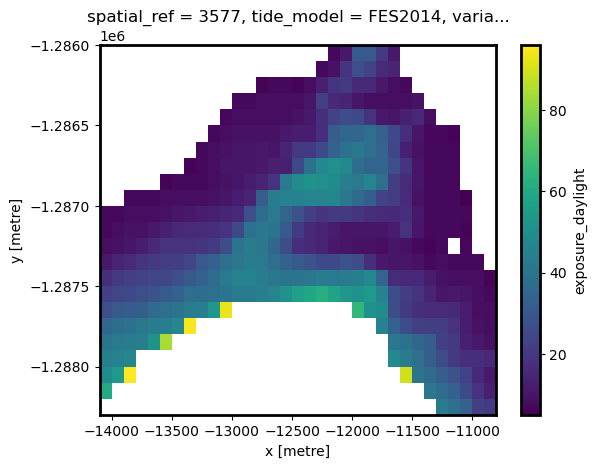

In [20]:
ds.exposure_daylight.plot()

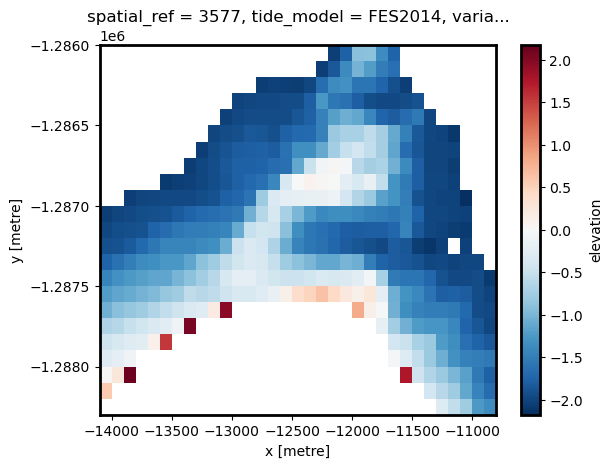

In [21]:
ds.elevation.plot()

In [22]:
from dea_tools.coastal import model_tides, pixel_tides

from scipy.signal import argrelmax 
from scipy.signal import argrelmin 
from scipy.interpolate import interp1d 
import xarray as xr

from math import ceil

In [23]:
## Testing for spatial customisation (splicing up the tidal zone)

modelledtides = pixel_tides(
                ds,
                times=all_timerange,
                model=tide_model,
                directory = tide_model_dir)
                # directory = '../../gdata1/data/tide_models')
    

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Reprojecting tides into original array


100%|██████████| 8761/8761 [00:04<00:00, 1805.31it/s]


In [348]:
## Peak selections in xarray for single pixel
## Calculations for Spring/Neap/High/Low tides
## Hardcoded assumption: one spring high tide per 14 day half-lunar cycle

# Extract the modelling freq units
freq_unit = modelled_freq.split()[0][-1]
freq_value = modelled_freq.split()[0][:-1]
# Extract the number of modelled timesteps per 14 days
mod_timesteps = np.timedelta64(14,'D') / np.timedelta64(freq_value,freq_unit)

# Modelledtides for pixel y1x1
test_mt = modelledtides[0].isel(y=1,x=1)

## Calculate the (spring) highest and lowest tides per 14 day half lunar cycle
springhighs = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values,
                                order=(int(mod_timesteps/2)))[0])
springlows = np.array(argrelmin(modelledtides[0].isel(y=1,x=1).values,
                                order=(int(mod_timesteps/2)))[0])

## Calculate the neap high and low tides per 14 day half lunar cycle
# Calculate all the high tide maxima
Max_test = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values)[0])
# Calculate the neap high tide minima per half lunar cycle, based on the number of spring high maxima
neaphighs = np.array(argrelmin(test_mt[Max_test].values,
                              order=(int(ceil((len(test_mt[Max_test])/len(springhighs))/2))))[0])
# Calculate all the low tide minima
Min_test = np.array(argrelmin(modelledtides[0].isel(y=1,x=1).values)[0])
# Calculate the neap low tide maxima per half lunar cycle, based on the number of spring low minima
neaplows = np.array(argrelmax(test_mt[Min_test].values,
                              order=(int(ceil((len(test_mt[Min_test])/len(springlows))/2))))[0])

# if 'Spring_high':
#     time_range = test_mt[springhighs].time.values
# if 'Spring_low':
#     time_range = test_mt[springlows].time.values
# if 'Neap_high':
#     time_range = test_mt[Max_test][neaphighs].time.values
# if 'Neap_low':
#     time_range = test_mt[Min_test][neaplows].time.values

## Calculate all hightide and lowtide peaks

# Create a dataset to model into, same length as test_mt (modelledtides) but without 
# the complication of datetimes
count = np.arange(0,len(test_mt),1)

## Need to extract the maxima and minima from the high and low tide maxima respectively
Max_max = np.array(argrelmax(test_mt[Max_test].values)[0])
Max_min = np.array(argrelmin(test_mt[Max_test].values)[0])

Min_max = np.array(argrelmax(test_mt[Min_test].values)[0])
Min_min = np.array(argrelmin(test_mt[Min_test].values)[0])


## Interpolate the high and low spring and neap curves
# neap high tide curve
neap_high_linear = interp1d(Max_test[Max_min], 
                            test_mt[Max_test][Max_min].values, 
                            bounds_error=False, 
                            kind='linear', 
                            fill_value='extrapolate'
                           )
neap_high_testline = neap_high_linear(count)
# # spring high tide curve
# spring_high_linear = interp1d(Max_test[Max_max], 
#                               test_mt[Max_test][Max_max].values, 
#                               bounds_error=False, 
#                               kind='linear', 
#                               fill_value='extrapolate'
#                              )
# spring_high_testline = spring_high_linear(count)
# neap low tide curve
neap_low_linear = interp1d(Min_test[Min_max], 
                           test_mt[Min_test][Min_max].values, 
                           bounds_error=False, 
                           kind='linear', 
                           fill_value='extrapolate')
neap_low_testline = neap_low_linear(count)
# # spring low tide curve
# spring_low_linear = interp1d(Min_test[Min_min], 
#                              test_mt[Min_test][Min_min].values, 
#                              bounds_error=False, 
#                              kind='linear', 
#                              fill_value='extrapolate')
# spring_low_testline = spring_low_linear(count)
# turn test_mt (modelledtides) into xr.Dataset
test_mt = test_mt.to_dataset()
# append the extrapolated tidelines for the lowest high tides and
# highest low tides (not really neap - more neap-esque)
test_mt['neap_high_testline'] = (('time'), neap_high_testline)
test_mt['neap_low_testline'] = (('time'), neap_low_testline)
# Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
hightide = test_mt['tide_m'].where(test_mt['tide_m'] >= test_mt['neap_high_testline'], drop=True)
# Extract lowtides as all tides lower than/equal to the extrapolated highest low tide line
lowtide = test_mt['tide_m'].where(test_mt['tide_m'] <= test_mt['neap_low_testline'], drop=True)
# Extract datetimes to run through exposure module
# if 'Hightide':
#     time_range = hightide.time.values
# if 'Lowtide':
#     time_range = lowtide.time.values

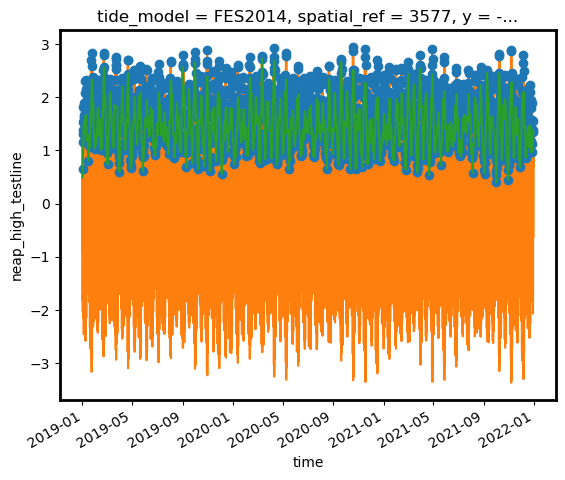

In [87]:
## Plots to check outputs of high and low tide selections
hightide[0:-1].plot(zorder=2, marker='o', linestyle='')
# lowtide[0:500].plot(zorder=3)#, marker='o', linestyle='')
test_mt.tide_m[0:-1].plot(zorder=1)#, marker='o', linestyle='')
test_mt.neap_high_testline[0:-1].plot()
# test_mt.neap_low_testline[0:2000].plot(zorder=10)


NameError: name 'spring_high_testline' is not defined

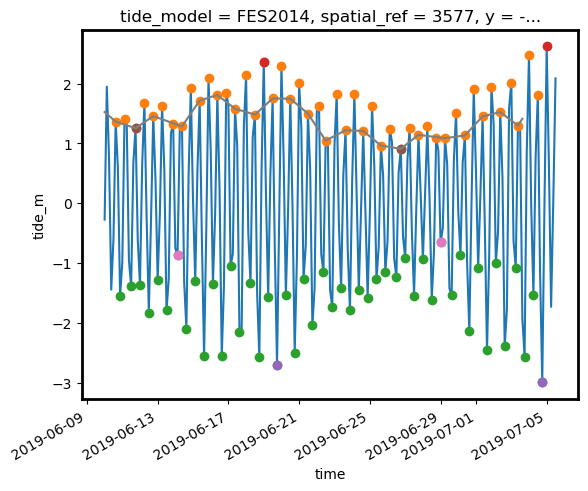

In [27]:
# Plots to check outputs of spring and neap tides selections

# BEWARE: if this cell isn't working, check test_mt as it was prototyped as an 
# xr.Dataarray but was later converted to xr.Dataset

test_mt.tide_m[1280:1485].plot(zorder=0)#ylim=0) #Modelledtides
test_mt.tide_m[Max_test][310:357].plot(marker='o', linestyle='')
test_mt.tide_m[Min_test][310:357].plot(marker='o', linestyle='', zorder=1)

test_mt.tide_m[springhighs][11:13].plot(marker='o', linestyle='') 
test_mt.tide_m[springlows][11:13].plot(marker='o', linestyle='', zorder=2) 
test_mt.tide_m[Max_test][neaphighs][11:13].plot(marker='o', linestyle='')
test_mt.tide_m[Min_test][neaplows][11:13].plot(marker='o', linestyle='', zorder=100)

plt.plot(test_mt.tide_m[1280:1470].time, neap_high_testline[1280:1470])
plt.plot(test_mt.tide_m[1280:1470].time, spring_high_testline[1280:1470])
plt.plot(test_mt.tide_m[1280:1470].time, neap_low_testline[1280:1470])
plt.plot(test_mt.tide_m[1280:1470].time, spring_low_testline[1280:1470])


In [136]:
## Peak selections in xarray for whole arrays
## Calculations for Spring/Neap/High/Low tides
## Hardcoded assumption: one spring high tide per 14 day half-lunar cycle
test_filters = ['Spring_high','Hightide','Neap_high'] # 'Spring_high' must run by default as its outputs are required for neap tide detection
# Extract the modelling freq units
freq_unit = modelled_freq.split()[0][-1]
freq_value = modelled_freq.split()[0][:-1]
# Extract the number of modelled timesteps per 14 days
mod_timesteps = np.timedelta64(14,'D') / np.timedelta64(freq_value,freq_unit)
## Identify kwargs for peak detection algorithm
order=(int(mod_timesteps/2))

## Calculate the spring highest and spring lowest tides per 14 day half lunar cycle
if 'Spring_high' in test_filters:
    ## stack the y and x dimensions
    stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
    ## apply the peak detection routine
    stacked_everything = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values, order=order)[0]))
    ## Unstack
    springhighs_all = stacked_everything.unstack('z')
    ##Reorder the y axis. Uncertain why it gets reversed during the stack/unstack.
    springhighs_all = springhighs_all.reindex(y=springhighs_all.y[::-1])
    ## Rename the time axis
    springhighs_all = springhighs_all.rename({'dim_0':'time'})
    ## Convert to dataset
    springhighs_all = springhighs_all.to_dataset(name = 'time')
    ## Reorder the dims
    springhighs_all = springhighs_all[['time','y','x']]
    ## Select dates associated with detected peaks
    springhighs_all = modelledtides[0].to_dataset().isel(time=springhighs_all.time)
    ## Extract the peak height dates
    # time_range = test_mt[springhighs].time.values
    
if 'Neap_high' in test_filters:
    ## stack the y and x dimensions
    stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    Max_testarray = modelledtides[0].to_dataset().isel(time=Max_testarray.time)
    
    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')
    ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
    ## relative to the number of spring high tide values
    order = int(ceil((len(Max_testarray.time)/(len(springhighs_all.time))/2)))
    ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
    neaphighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values, order=order)[0]))
    ## unstack and format as above                                    
    neaphighs_all = neaphighs_all.unstack('z')
    neaphighs_all = (
                    neaphighs_all
                     .reindex(y=neaphighs_all.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract neap high tides
    neaphighs_all = Max_testarray.isel(time=neaphighs_all.time)
    
if 'Hightide' in test_filters:
    ## stack the y and x dimensions
    stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    Max_testarray = modelledtides[0].to_dataset().isel(time=Max_testarray.time)  
    
    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')
    
#     ## extract lower ('neap ish') high tides 
#     lowhighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values)[0]))
# #     ## unstack and format as above                                    
# #     lowhighs_all = lowhighs_all.unstack('z')
# #     lowhighs_all = (
# #                     lowhighs_all
# #                      .reindex(y=lowhighs_all.y[::-1])
# #                      .rename({'dim_0':'time'})
# #                      .to_dataset(name = 'time')
# #                      [['time','y','x']]
# #                     )
# #     ## extract neap high tides
# #     lowhighs_all = Max_testarray.isel(time=lowhighs_all.time)
    
# #     ## Stack and interpolate the lower curve of the high tide peaks
# #     stacked_everything3 = lowhighs_all.tide_m.stack(z=['y','x']).groupby('z')
# #     lowhighcurve = stacked_everything3. apply(lambda x: xr.DataArray(interp1d(x.time,
# #                                                                               x.tide_m,
# #                                                                               bounds_error=False,
# #                                                                               kind='linear',
# #                                                                               fill_value='extrapolate')))
# lowhighs_all
    
#     # Create a dataset to model into, same length as test_mt (modelledtides) but without 
#     # the complication of datetimes
#     count = np.arange(0,len(test_mt),1)

#     ## Need to extract the maxima and minima from the high and low tide maxima respectively
#     Max_max = np.array(argrelmax(test_mt[Max_test].values)[0])
#     Max_min = np.array(argrelmin(test_mt[Max_test].values)[0])

#     Min_max = np.array(argrelmax(test_mt[Min_test].values)[0])
#     Min_min = np.array(argrelmin(test_mt[Min_test].values)[0])


#     ## Interpolate the high and low spring and neap curves
#     # neap high tide curve
#     neap_high_linear = interp1d(Max_test[Max_min], 
#                                 test_mt[Max_test][Max_min].values, 
#                                 bounds_error=False, 
#                                 kind='linear', 
#                                 fill_value='extrapolate'
#                                )
#     neap_high_testline = neap_high_linear(count)
    
    
    
    
    
    
    
    
    
    
    
    
    # Max_testarray2 = stacked_everything[Max_testarray]
    # # Calculate the neap high tide minima per half lunar cycle, based on the number of spring high maxima
    # neaphighs = Max_testarray.apply(lambda x: xr.DataArray(argrelmin(test_mt[Max_test].values,
    #                           order=(int(ceil((len(test_mt[Max_test])/len(springhighs))/2))))[0])
    
    
    ## Unstack
    # neaphighs_all = stacked_everything.unstack('z')
    # ##Reorder the y axis. Uncertain why it gets reversed during the stack/unstack.
    # neaphighs_all = neaphighs_all.reindex(y=neaphighs_all.y[::-1])
    # ## Rename the time axis
    # neaphighs_all = neaphighs_all.rename({'dim_0':'time'})
    # ## Convert to dataset
    # neaphighs_all = neaphighs_all.to_dataset(name = 'time')
    # ## Reorder the dims
    # neaphighs_all = neaphighs_all[['time','y','x']]
    # ## Select dates associated with detected peaks
    # neaphighs_all = modelledtides[0].to_dataset().isel(time=neaphighs_all.time)
    ## Extract the peak height dates
    # time_range = test_mt[springhighs].time.values    


# springhighs = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values,
#                                 order=(int(mod_timesteps/2)))[0])
# springlows = np.array(argrelmin(modelledtides[0].isel(y=1,x=1).values,
#                                 order=(int(mod_timesteps/2)))[0])

# ## Calculate the neap high and low tides per 14 day half lunar cycle
# # Calculate all the high tide maxima
# Max_test = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values)[0])
# # Calculate the neap high tide minima per half lunar cycle, based on the number of spring high maxima
# neaphighs = np.array(argrelmin(test_mt[Max_test].values,
#                               order=(int(ceil((len(test_mt[Max_test])/len(springhighs))/2))))[0])
# # Calculate all the low tide minima
# Min_test = np.array(argrelmin(modelledtides[0].isel(y=1,x=1).values)[0])
# # Calculate the neap low tide maxima per half lunar cycle, based on the number of spring low minima
# neaplows = np.array(argrelmax(test_mt[Min_test].values,
#                               order=(int(ceil((len(test_mt[Min_test])/len(springlows))/2))))[0])

 # if 'Spring_low':
# #     time_range = test_mt[springlows].time.values
# # if 'Neap_high':
# #     time_range = test_mt[Max_test][neaphighs].time.values
# # if 'Neap_low':
# #     time_range = test_mt[Min_test][neaplows].time.values

# ## Calculate all hightide and lowtide peaks

# # Create a dataset to model into, same length as test_mt (modelledtides) but without 
# # the complication of datetimes
# count = np.arange(0,len(test_mt),1)

# ## Need to extract the maxima and minima from the high and low tide maxima respectively
# Max_max = np.array(argrelmax(test_mt[Max_test].values)[0])
# Max_min = np.array(argrelmin(test_mt[Max_test].values)[0])

# Min_max = np.array(argrelmax(test_mt[Min_test].values)[0])
# Min_min = np.array(argrelmin(test_mt[Min_test].values)[0])


# ## Interpolate the high and low spring and neap curves
# # neap high tide curve
# neap_high_linear = interp1d(Max_test[Max_min], 
#                             test_mt[Max_test][Max_min].values, 
#                             bounds_error=False, 
#                             kind='linear', 
#                             fill_value='extrapolate'
#                            )
# neap_high_testline = neap_high_linear(count)
# # spring high tide curve
# spring_high_linear = interp1d(Max_test[Max_max], 
#                               test_mt[Max_test][Max_max].values, 
#                               bounds_error=False, 
#                               kind='linear', 
#                               fill_value='extrapolate'
#                              )
# spring_high_testline = spring_high_linear(count)
# # neap low tide curve
# neap_low_linear = interp1d(Min_test[Min_max], 
#                            test_mt[Min_test][Min_max].values, 
#                            bounds_error=False, 
#                            kind='linear', 
#                            fill_value='extrapolate')
# neap_low_testline = neap_low_linear(count)
# # spring low tide curve
# spring_low_linear = interp1d(Min_test[Min_min], 
#                              test_mt[Min_test][Min_min].values, 
#                              bounds_error=False, 
#                              kind='linear', 
#                              fill_value='extrapolate')
# spring_low_testline = spring_low_linear(count)
# # turn test_mt (modelledtides) into xr.Dataset
# test_mt = test_mt.to_dataset()
# # append the extrapolated tidelines for the lowest high tides and
# # highest low tides (not really neap - more neap-esque)
# test_mt['neap_high_testline'] = (('time'), neap_high_testline)
# test_mt['neap_low_testline'] = (('time'), neap_low_testline)
# # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
# hightide = test_mt['tide_m'].where(test_mt['tide_m'] >= test_mt['neap_high_testline'], drop=True)
# # Extract lowtides as all tides lower than/equal to the extrapolated highest low tide line
# lowtide = test_mt['tide_m'].where(test_mt['tide_m'] <= test_mt['neap_low_testline'], drop=True)
# # Extract datetimes to run through exposure module
# # if 'Hightide':
# #     time_range = hightide.time.values
# # if 'Lowtide':
# #     time_range = lowtide.time.values

In [143]:
t = modelledtides[0].isel(y=1,x=1)
a = t.y.values
b = t.x.values
print (a,b)

-1286150.0 -13950.0


In [145]:
t

<xarray.DataArray 'tide_m' (time: 8761)>
array([-2.0282042 , -0.6058837 ,  1.3114041 , ...,  1.4019824 ,
        0.68070245, -1.9132433 ], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 ... 2021-12-31
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
    y            float64 -1.286e+06
    x            float64 -1.395e+04

In [144]:
modelledtides[0].sel(y=a,x=b)

<xarray.DataArray 'tide_m' (time: 8761)>
array([-2.0282042 , -0.6058837 ,  1.3114041 , ...,  1.4019824 ,
        0.68070245, -1.9132433 ], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 ... 2021-12-31
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
    y            float64 -1.286e+06
    x            float64 -1.395e+04

In [205]:
# stacked_everything333#.time.values
interplowhigharray = xr.DataArray(data = neap_high_testline,
                            dims = ['time'],
                            coords=(dict(time=stacked_everything.time.values))
                           )
interplowhigharray

<xarray.DataArray (time: 8761)>
array([1.5463332e+18, 1.5463764e+18, 1.5464196e+18, ..., 1.9278648e+18,
       1.9279080e+18, 1.9279512e+18])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-01T03:00:00 ... 2021-12-31

In [377]:
## Master draft for single pixel hightides workflow

## Reference func
# lowhighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values)[0]))

## Identify single pixel for testing
t = modelledtides[0].isel(y=1,x=1)
a = t.y.values
b = t.x.values

## stack the y and x dimensions
# stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
stacked_everything =  modelledtides[0].sel(y=a,x=b)
''' -----------------------------------------------------------'''

## apply the peak detection routine to calculate all the high tide maxima
# Max_testarray = stacked_everything.apply(lambda y: xr.DataArray(argrelmax(y.values)[0]))
Max_testarray1 = np.array(argrelmax(stacked_everything.values)[0])

## extract the corresponding dates from the peaks
# Max_testarray = (Max_testarray.unstack('z'))
# Max_testarray = (
#                  Max_testarray
#                  # .reindex(y=Max_testarray.y[::-1])
#                  # .rename({'dim_0':'time'})
#                  .to_dataset(name = 'time')
#                  [['time','y','x']]
#                 )

Max_testarray = stacked_everything.isel(time=Max_testarray1)

## Simulate a single z grouping
# stacked_everything3 = Max_testarray.tide_m#.isel(y=[1],x=[1])#.stack(z=['y','x']).groupby('z')

## Identify all lower hightide peaks
stacked_everything33 = np.array(argrelmin(Max_testarray.values)[0])

## Extract all tide heights associated with lower hightide peaks
# stacked_everything333 = stacked_everything3.isel(time=stacked_everything33)
stacked_everything333 = Max_testarray.isel(time=stacked_everything33)#######################################
# stacked_everything333 = stacked_everything.isel(time=stacked_everything33)#######################################
stacked_everything3333 = stacked_everything.sel(time=stacked_everything333.time)
test = stacked_everything.isel(time=Max_testarray1).isel(time=stacked_everything33)

## Interpolate the lower hightide curve
neap_high_linear = interp1d(
                        Max_testarray1[stacked_everything33], ## low high peaks
                        # np.arange(0,len(stacked_everything333.values),1), ## generic array
                        # stacked_everything3333.values, ## tide_m
                        # stacked_everything3333.values,
                        # Max_testarray.values,
                        Max_testarray.isel(time=stacked_everything33).values,
                        # test.values,
                        # stacked_everything333.time.values, ## datetimes
                        # stacked_everything333.squeeze(['y','x']).values,
                        # stacked_everything333.values,
                        bounds_error=False, 
                        kind='linear', 
                        fill_value='extrapolate'
                      )
## Create an array to interpolate into sans datetimes
count = np.arange(0,len(stacked_everything),1)
# count = np.arange(0,len(stacked_everything3.time),1)
neap_high_testline_vec = neap_high_linear(count)

# interplowhigharray = xr.DataArray(data = neap_high_testline,
#                             dims = ['time'],
#                             coords=(dict(time=stacked_everything.time.values))
#                            )

# interplowhigharray.plot()
# test_mt = test_mt.to_dataset()

# # append the extrapolated tidelines for the lowest high tides and
# # highest low tides (not really neap - more neap-esque)
# test_mt['neap_high_testline'] = (('time'), neap_high_testline)
# test_mt['neap_low_testline'] = (('time'), neap_low_testline)

# # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
# hightide = test_mt['tide_m'].where(test_mt['tide_m'] >= test_mt['neap_high_testline'], drop=True)
hightide = stacked_everything.where(stacked_everything >= neap_high_testline_vec, drop=True)

# # Extract lowtides as all tides lower than/equal to the extrapolated highest low tide line
# lowtide = test_mt['tide_m'].where(test_mt['tide_m'] <= test_mt['neap_low_testline'], drop=True)

## Calculate exposure using regular method
calculate_quantiles = np.linspace(0, 1, 11)#101)

tide_cq = hightide.quantile(q=calculate_quantiles,dim='time')

# Calculate the tide-height difference between the elevation value and
# each percentile value per pixel
diff = abs(tide_cq - ds.sel(y=a,x=b).elevation)

# Take the percentile of the smallest tide-height difference as the
# exposure % per pixel
idxmin = diff.idxmin(dim="quantile")

# Convert to percentage
exposure = idxmin * 100

exposure

<xarray.DataArray 'quantile' ()>
array(nan)
Coordinates:
    y            float64 -1.286e+06
    x            float64 -1.395e+04
    spatial_ref  int32 3577
    tide_model   <U7 'FES2014'
    variable     <U4 'ndwi'

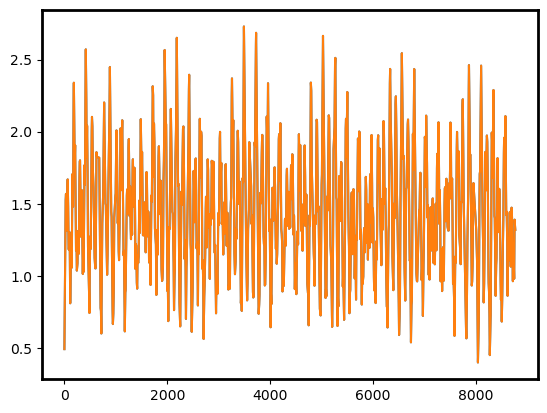

In [378]:
plt.plot(np.arange(0, len(neap_high_testline),1), neap_high_testline)
plt.plot(np.arange(0, len(neap_high_testline_vec),1), neap_high_testline_vec)

In [312]:
# test_mt = test_mt.to_dataset()
# # append the extrapolated tidelines for the lowest high tides and
# # highest low tides (not really neap - more neap-esque)
# test_mt['neap_high_testline'] = (('time'), neap_high_testline)

stacked_everything_ds = stacked_everything.to_dataset()
stacked_everything_ds['neap_high_testline'] = (('time'), neap_high_testline)
# Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
hightide = stacked_everything_ds['tide_m'].where(stacked_everything_ds['tide_m'] >= stacked_everything_ds['neap_high_testline'], drop=True)

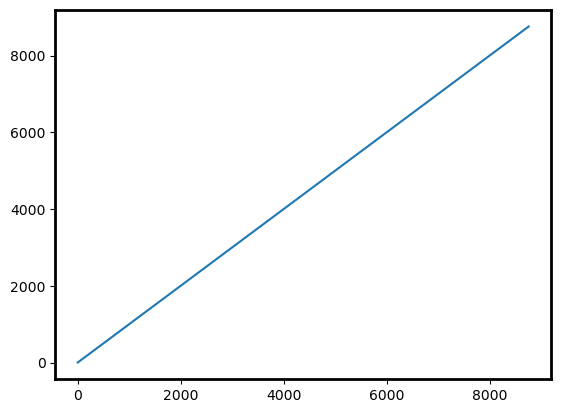

In [355]:
## Identical high tide peaks detected in single pixel and array based analyses
plt.plot(Max_testarray1, Max_test)

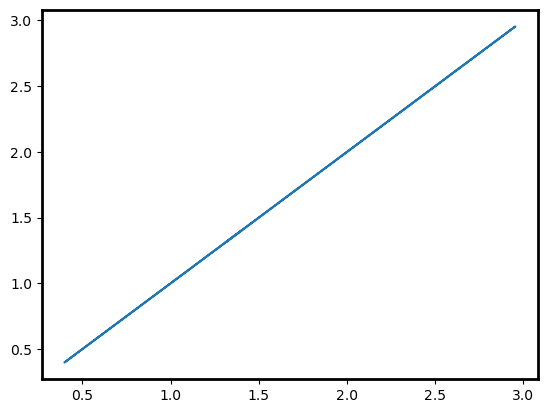

In [357]:
## Same tideheights extracted for hightides from modelledtides dataset
plt.plot(Max_testarray, test_mt.tide_m[Max_test])

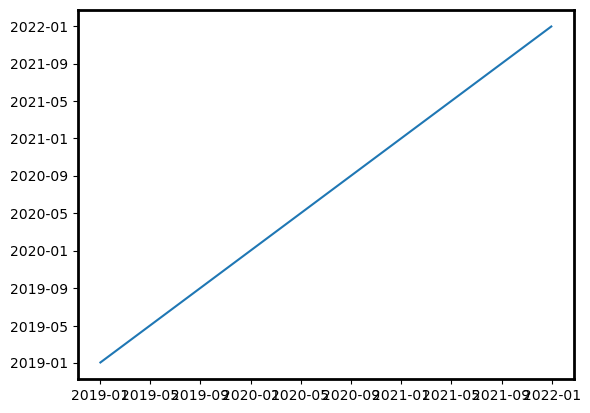

In [366]:
## Same datetimes extracted for hightides from modelledtides dataset
plt.plot(Max_testarray.time, test_mt.tide_m[Max_test].time)

In [375]:
print(Max_test[Max_min])
print(Max_min)

[  15   23   31   39   48   56   64   72   80   89   97  105  113  130
  143  151  159  168  176  184  192  201  209  217  226  234  242  255
  263  271  280  288  296  304  312  321  329  337  345  358  366  374
  383  391  399  408  416  424  433  441  449  457  470  478  487  495
  503  511  520  528  536  544  552  565  585  598  606  615  623  631
  677  701  710  718  727  735  743  752  772  796  805  821  830  838
  847  867  876  884  908  917  933  942  950  959  967  987  996 1004
 1012 1020 1028 1037 1045 1053 1062 1070 1091 1099 1107 1116 1124 1140
 1149 1157 1165 1174 1182 1190 1211 1219 1227 1236 1244 1252 1260 1269
 1277 1285 1294 1302 1315 1323 1331 1339 1348 1356 1364 1372 1380 1389
 1397 1405 1414 1422 1434 1443 1451 1459 1467 1476 1484 1492 1501 1509
 1517 1526 1542 1555 1563 1571 1580 1588 1596 1604 1612 1621 1629 1637
 1645 1658 1666 1674 1683 1691 1699 1708 1716 1724 1732 1741 1749 1757
 1778 1787 1795 1803 1811 1820 1828 1836 1844 1852 1861 1869 1885 1898
 1906 

906

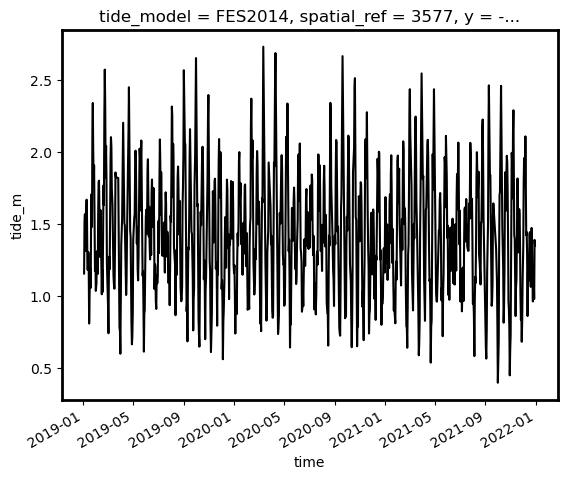

In [353]:
# hightide.plot()
test_mt.tide_m[Max_test][Max_min].plot(color='black')
len(test_mt.tide_m[Max_test][Max_min])
# stacked_everything.plot(color='red')

906
906


2116

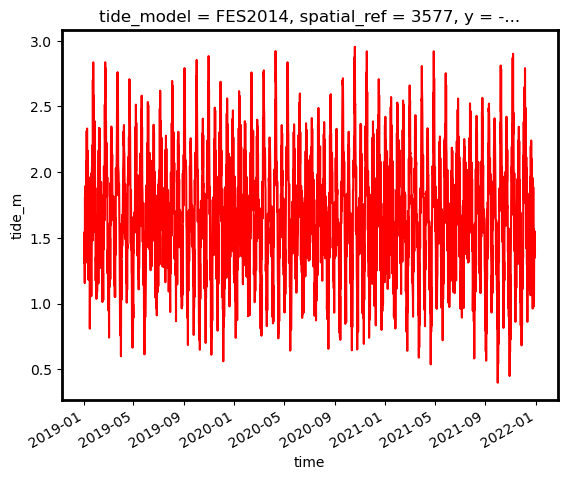

In [354]:
Max_testarray.plot(color='red')

print(len(Max_testarray.isel(time=stacked_everything33)))# == 
print(len(test_mt.tide_m[Max_test][Max_min]))
len(Max_testarray)
# test_mt.tide_m == stacked_everything

In [345]:
print(Max_testarray.isel(time=stacked_everything33))
print(test_mt.tide_m[Max_test][Max_min])

<xarray.DataArray 'tide_m' (time: 906)>
array([1.1560715 , 1.5109955 , 1.5681508 , 1.3654356 , 1.313831  ,
       1.6002665 , 1.6685401 , 1.5234028 , 1.1858912 , 1.1805583 ,
       1.3039885 , 1.189641  , 0.808715  , 1.1975794 , 1.0561461 ,
       1.5496678 , 1.7067314 , 1.4798421 , 2.144471  , 2.339722  ,
       2.0076191 , 1.784865  , 1.9062917 , 1.5434744 , 1.1747451 ,
       1.2949753 , 1.0354928 , 1.0871328 , 1.3100696 , 1.2789806 ,
       1.1528845 , 1.5703964 , 1.7896729 , 1.8008506 , 1.6060264 ,
       1.2716564 , 1.5501623 , 1.5944926 , 1.3346796 , 1.0120188 ,
       1.1841426 , 1.0270982 , 1.413391  , 1.767495  , 1.6321841 ,
       2.25793   , 2.5713284 , 2.3412158 , 1.8222951 , 2.0419219 ,
       1.81379   , 1.2299678 , 1.0390676 , 0.94536877, 0.74135876,
       1.1271312 , 1.273187  , 1.1859953 , 1.5953819 , 1.9502438 ,
       2.1026547 , 2.0375607 , 1.7469409 , 1.6355155 , 1.1386815 ,
       1.0515931 , 1.0506998 , 1.371497  , 1.8574928 , 1.824965  ,
       1.8191777 , 0.7

In [307]:
len(Max_testarray1)
# stacked_everything33

test = stacked_everything.isel(time=Max_testarray1).isel(time=stacked_everything33)

In [383]:
print(len(Max_testarray))
print(len(hightide))
      

2116
2247


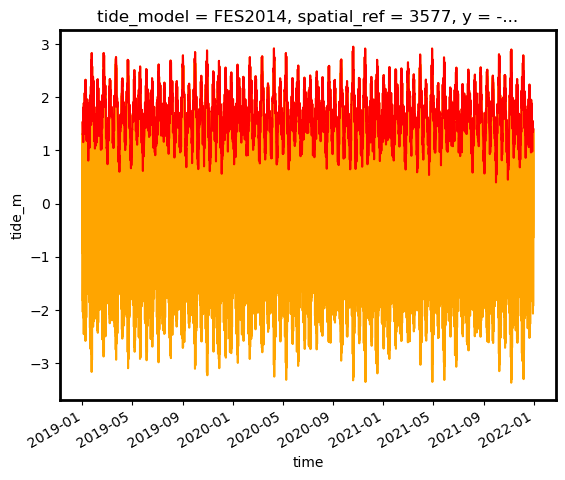

In [382]:
# Max_testarray.values


# stacked_everything333#.squeeze(['y','x']).values
Max_testarray.plot(zorder=5, color='red')
# stacked_everything333.plot(zorder=10, color='lightblue')

# hightide.plot(zorder=20, color='blue')
stacked_everything.plot(zorder=0, color='orange')
# plt.plot(np.arange(0,len(neap_high_testline),1), neap_high_testline)

906

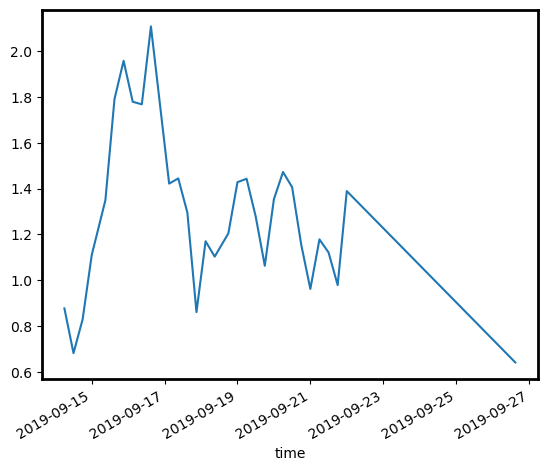

In [277]:
# # print(stacked_everything)
# # interplowhigharray
# # len(stacked_everything333.values)
# # neap_high_testline[0]
# print(len(stacked_everything33))
# print(len(Max_testarray))
interplowhigharray[2050:2150].plot()
# len(stacked_everything)
# # hightide = stacked_everything.where(stacked_everything >= interplowhigharray, drop=True)
# # stacked_everything333.values

# stacked_everything333.time
stacked_everything3333 = stacked_everything.sel(time=stacked_everything333.time)
len(stacked_everything3333)

In [295]:
# # test_mt.tide_m[Max_test][Max_min].values
# stacked_everything3333
# len(stacked_everything33)
# Max_testarray
test = stacked_everything.sel(time=Max_testarray.time).sel(time=stacked_everything333.time)
# test

len(stacked_everything33)
len(test_mt.tide_m[Max_test][Max_min])
len(test_mt.tide_m)
# stacked_everything.sel(Max_testarray.time)

8761

In [163]:
# modelledtides[0].isel(y=1,x=1).time
# hightide.plot()
ds.sel

<xarray.Dataset>
Dimensions:                (y: 23, x: 33)
Coordinates:
  * y                      (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06
  * x                      (x) float64 -1.405e+04 -1.395e+04 ... -1.085e+04
    spatial_ref            int32 3577
    tide_model             <U7 'FES2014'
    variable               <U4 'ndwi'
Data variables:
    elevation              (y, x) float32 nan nan nan ... -0.7646 -1.257 -1.368
    elevation_uncertainty  (y, x) float32 nan nan nan ... 0.1588 0.6183 0.6776
    extents                (y, x) float64 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    exposure_daylight      (y, x) float64 nan nan nan nan ... 33.0 22.0 20.0

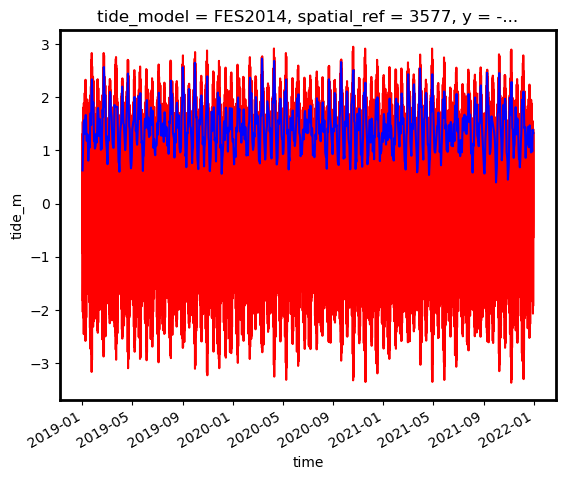

In [72]:

# plt.plot(modelledtides[0].isel(y=1,x=1).time, neap_high_testline, color='blue', zorder=1)
plt.plot(Max_testarray.time.isel(y=1,x=1).values, neap_high_testline, color='blue', zorder=1)
modelledtides[0].isel(y=1,x=1).plot(zorder=0, color='red')

ht = modelledtides[0].isel(y=1,x=1).where(modelledtides[0].isel(y=1,x=1)>=


# hightide.plot(color='orange', zorder=0)
# neap_high_testline.plot()
# len(modelledtides[0])

In [137]:
## Working draft to convert hightides workflow to fun to run through xr.DataArray.apply

## Reference func
# lowhighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values)[0]))

def highlowtides(x, b):
    '''
    x is a grouping of x and y pixels from the peaks_array (labelled as 'z')
    
    b is the length of the original modelledtides[0] array
    '''
   
    # ## stack the y and x dimensions
    # stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = x.apply(lambda y: xr.DataArray(argrelmax(y.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    Max_testarray = modelledtides[0].to_dataset().isel(time=Max_testarray.time)  
    
    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')


    # ## Simulate a single z grouping
    # stacked_everything3 = Max_testarray.tide_m.isel(y=[1],x=[1])#.stack(z=['y','x']).groupby('z')

    ## Identify all lower hightide peaks
    # stacked_everything33 = np.array(argrelmin(stacked_everything3.values)[0])
    stacked_everything33 = np.array(argrelmin(x.values)[0])

    ## Extract all tide heights associated with lower hightide peaks
    # stacked_everything333 = stacked_everything3.isel(time=stacked_everything33)
    # stacked_everything333 = x.isel(time=stacked_everything33)
    stacked_everything333 = x[stacked_everything33]
    # stacked_everything333 = x.where(np.isin(x.time,stacked_everything333.time))

    ## Interpolate the lower hightide curve
    neap_high_linear = interp1d(stacked_everything33, 
                            # stacked_everything333.isel(y=0,x=0), # z=0 in stacked arrays?
                            # stacked_everything333,#.isel(z=x), # z=0 in stacked arrays?
                            stacked_everything333.squeeze(['z']).values,
                            bounds_error=False, 
                            kind='linear', 
                            fill_value='extrapolate'
                          )
    ## Create an array to interpolate into sans datetimes
    count = np.arange(0,b,1)
    neap_high_testline = neap_high_linear(count)

    return neap_high_testline
#     # test_mt = test_mt.to_dataset()

#     # # append the extrapolated tidelines for the lowest high tides and
#     # # highest low tides (not really neap - more neap-esque)
#     # test_mt['neap_high_testline'] = (('time'), neap_high_testline)
#     # test_mt['neap_low_testline'] = (('time'), neap_low_testline)

#     # # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
#     # hightide = test_mt['tide_m'].where(test_mt['tide_m'] >= test_mt['neap_high_testline'], drop=True)
#     hightide = modelledtides[0].isel(y=1,x=1).where(modelledtides[0].isel(y=1,x=1) >= neap_high_testline,drop=True)

#     # # Extract lowtides as all tides lower than/equal to the extrapolated highest low tide line
#     # lowtide = test_mt['tide_m'].where(test_mt['tide_m'] <= test_mt['neap_low_testline'], drop=True)

#     ## Calculate exposure using regular method
#     calculate_quantiles = np.linspace(0, 1, 11)#101)

#     tide_cq = hightide.quantile(q=calculate_quantiles,dim='time')

#     # Calculate the tide-height difference between the elevation value and
#     # each percentile value per pixel
#     diff = abs(tide_cq - ds.isel(y=1,x=1).elevation)

#     # Take the percentile of the smallest tide-height difference as the
#     # exposure % per pixel
#     idxmin = diff.idxmin(dim="quantile")

#     # Convert to percentage
#     exposure = idxmin * 100

## stack the y and x dimensions
stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 

## Vectorise the hightide calculation
lowhighs_all = stacked_everything.apply(lambda x: xr.DataArray(highlowtides(x,len(modelledtides[0]))))

## Unstack and re-format the array
lowhighs_all = lowhighs_all.unstack('z')
lowhighs_all_unstacked = (
                    lowhighs_all
                     .reindex(y=lowhighs_all.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
## Format array
lowhighs_all_unstacked = lowhighs_all_unstacked.rename_vars({'time':'tide_m'})
lowhighs_all_unstacked = lowhighs_all_unstacked.assign_coords({'time': modelledtides[0].time})



In [138]:
lowhighs_all_unstacked

<xarray.Dataset>
Dimensions:      (time: 8761, y: 23, x: 33)
Coordinates:
  * y            (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 -1.405e+04 -1.395e+04 ... -1.095e+04 -1.085e+04
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2019-01-01 ... 2021-12-31
Data variables:
    tide_m       (time, y, x) float64 0.6221 0.6232 0.6243 ... -189.2 -190.3

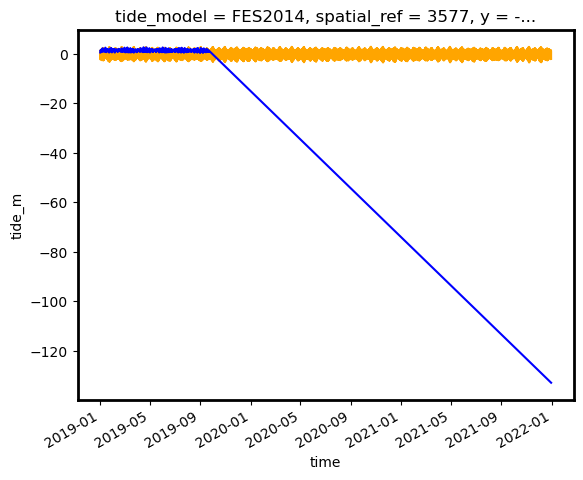

In [32]:
lowhighs_all_unstacked.tide_m.isel(y=1,x=1).plot(color='blue',zorder=1)
modelledtides[0].isel(y=1,x=1).plot(color='orange',zorder=0)

In [272]:
## Extract all hightide points
hightides = modelledtides[0].where(modelledtides[0] >= lowhighs_all_unstacked, drop=True)#neap_high_testline,drop=True)

# lowhighs_all_unstacked
hightides

IndexError: list index out of range

In [186]:
len(neap_high_testline)

8761

In [179]:
# def extrema (x, comparator, array):
#     extrema_peaks = argrelextrema(x, comparator)[0]
#     extrema = array.isel(z=x, time= extrema_peaks)
#     return extrema

# for z in stacked_everything2:
#     print (z)

In [143]:
# modelledtides[0].to_dataset()['neap_high_testline'] = (('time'), neap_high_testline)
hightide = modelledtides[0].isel(y=1,x=1).where(modelledtides[0].isel(y=1,x=1) >= neap_high_testline,drop=True)

In [180]:
hightide

<xarray.DataArray 'tide_m' (time: 2247)>
array([1.3114041 , 0.64365244, 1.5426903 , ..., 1.5512965 , 1.3487471 ,
       1.4019824 ], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T06:00:00 ... 2021-12-30T18:...
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
    y            float64 -1.286e+06
    x            float64 -1.395e+04

In [183]:
calculate_quantiles = np.linspace(0, 1, 11)#101)
# tide_cq = neaphighs_all.tide_m.quantile(q=calculate_quantiles,dim='time')
tide_cq = hightide.quantile(q=calculate_quantiles,dim='time')

# Calculate the tide-height difference between the elevation value and
# each percentile value per pixel
diff = abs(tide_cq - ds.elevation)

# Take the percentile of the smallest tide-height difference as the
# exposure % per pixel
idxmin = diff.idxmin(dim="quantile")

# Convert to percentage
exposure = idxmin * 100

# tide_cq
# diff
exposure

<xarray.DataArray 'quantile' ()>
array(nan)
Coordinates:
    y            float64 -1.286e+06
    x            float64 -1.395e+04
    spatial_ref  int32 3577
    tide_model   <U7 'FES2014'
    variable     <U4 'ndwi'

In [165]:
print (len(hightide))
print(len(Max_testarray.isel(y=1,x=1).tide_m))
neap_high_testline

2247
2116


array([0.49058911, 0.53495461, 0.5793201 , ..., 1.32853836, 1.32348616,
       1.31843397])

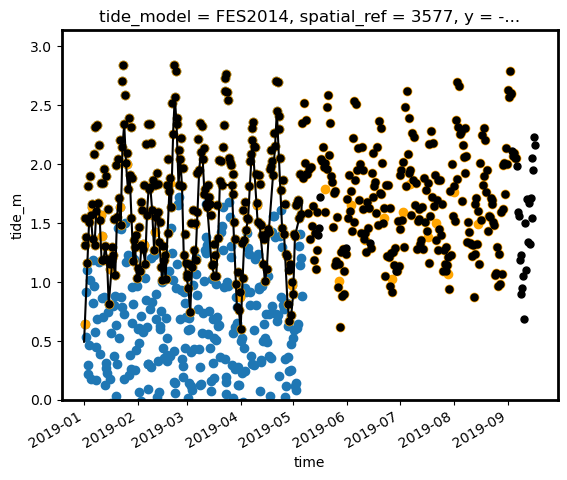

In [178]:
hightide[0:500].plot(zorder=1, marker='o', linestyle='', color='orange')
Max_testarray.isel(y=1,x=1).tide_m[0:500].plot(zorder=0, marker='o', linestyle='', color='black', markersize=5)
modelledtides[0][0:1000].isel(y=1,x=1).plot(ylim=0,zorder=0, marker='o', linestyle='')
plt.plot(modelledtides[0].isel(y=1,x=1).time[0:1000], neap_high_testline[0:1000], color='black', zorder=10)

In [ ]:
from scipy.signal import argrelextrema

In [125]:
maxmintest = argrelextrema(Max_testarray.tide_m.isel(y=1,x=1).values, np.less)
maxmintestdates = Max_testarray.tide_m.isel(y=1,x=1,time=maxmintest[0])
# maxmintest [0]

In [170]:
## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')


## extract lower ('neap ish') high tides 
# lowhighs_all = stacked_everything2.map(lambda x: xr.DataArray(argrelmin(x.values)[0]))
lowhighs_all = stacked_everything2.map(lambda x: xr.Dataset(data_vars=dict(
                                                                    peaks=(['time','z', str(x)]), 
                                                                    argrelextrema(x.values, np.less)[0])))#, dims=['peaks']))

In [158]:
Max_testarray.argmin()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
Data variables:
    tide_m       int64 1472460

In [97]:
# exposure.plot()
order = int(ceil((len(Max_testarray.time)/(len(springhighs_all.time)*14)/2)))
# order = int(ceil((len(Max_testarray.time)/(0.5*len(Max_testarray.time))/2)))

order

2

In [90]:
# len(Max_testarray.time)/(0.25*len(Max_testarray.time))
(0.05*len(springhighs_all.time))

3.7

In [182]:
# ## stack the dimensions and apply the peak detection routine
# stacked_exp1 = springhighs_all.tide_m.stack(z=['y','x']).groupby('z')
# stacked_dem = ds.elevation.stack(z=['y','x']).groupby('z')

# stacked_exp2 = stacked_exp1.apply(lambda x: xr.DataArray(x.quantile(q=calculate_quantiles,dim='time')))
# diff1 = abs(stacked_exp2 - stacked_dem)
# ## Unstack
# stacked_exp3 = diff1.unstack('z')

# ##Reorder the y axis. Uncertain why it gets reversed during the stack/unstack.
# stacked_exp4 = stacked_exp3.reindex(y=stacked_exp3.y[::-1])

# # diff = abs(stacked_exp4 - ds.elevation)

# idxmin = diff.idxmin(dim='quantile')

# # exposure = idxmin*100

# # stacked_exp4

# # ## Rename the time axis
# # springhighs_all = springhighs_all.rename({'dim_0':'time'})

# # ## Convert to dataset
# # springhighs_all = springhighs_all.to_dataset(name = 'time')

# # ## Reorder the dims
# # springhighs_all = springhighs_all[['time','y','x']]

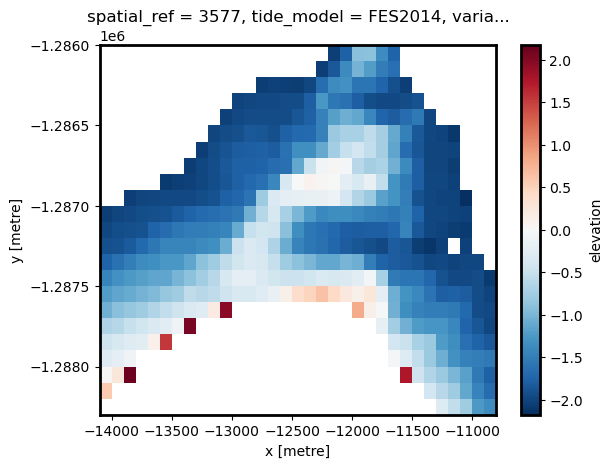

In [217]:
ds.elevation.plot()

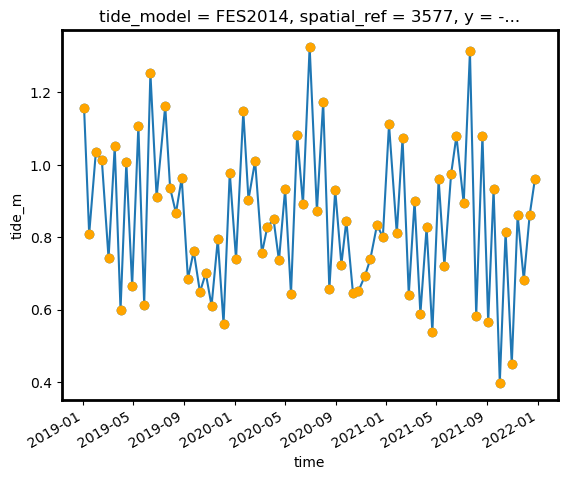

In [175]:
# plt.plot(springhighs_all.isel(y=1,x=1).time, springhighs_all.isel(y=1,x=1).tide_m, marker='o')
# plt.plot(neaphighs_all.isel(y=1,x=1).time, neaphighs_all.isel(y=1,x=1).tide_m, marker='o')
# plt.plot(springhighs_px.time, springhighs_px.tide_m, marker='o', linestyle='', color='red', zorder=2)
plt.plot(neaphighs_allx.isel(y=1,x=1).time, neaphighs_allx.isel(y=1,x=1).tide_m, marker='o', linestyle='', color='orange', zorder=3)
# plt.plot(neaphighs_px.time, neaphighs_px.tide_m, marker='o', zorder=1)#, linestyle='')
modelledtides[0][Max_test][neaphighs].isel(y=1,x=1).plot(marker='o',zorder=0)#, linestyle='')
# plt.plot(modelledtides[0].to_dataset().isel(y=1,x=1).time, modelledtides[0].to_dataset().isel(y=1,x=1).tide_m, zorder=0)

In [196]:
springhighs_px.time == springhighs_all.isel(y=1,x=1).time

<xarray.DataArray 'time' (time: 74)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])
Coordinates:
  * time         (time) datetime64[ns] 2019-01-08T12:00:00 ... 2021-12-21T12:...
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
    y            float64 -1.286e+06
    x            float64 -1.395e+04

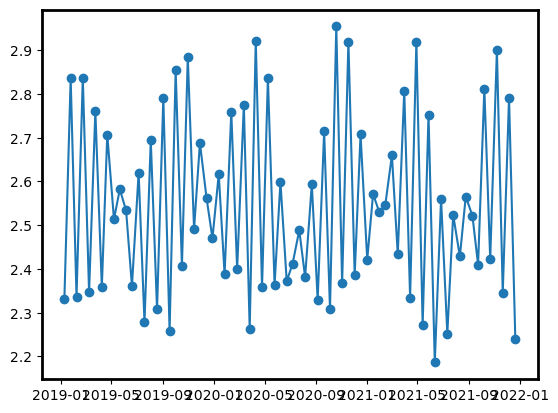

In [48]:
springhighs_px = modelledtides[0].to_dataset().isel(y=1,x=1,time=springhighs)

plt.plot(springhighs_px.time, springhighs_px.tide_m, marker='o')

In [188]:
springhighs_all = springhighs_all.rename({'dim_0':'time'})
springhighs_all = springhighs_all.to_dataset(name = 'time')

In [189]:

springhighs_all

<xarray.Dataset>
Dimensions:  (y: 23, x: 33, time: 74)
Coordinates:
  * y        (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x        (x) float64 -1.405e+04 -1.395e+04 ... -1.095e+04 -1.085e+04
Dimensions without coordinates: time
Data variables:
    time     (time, y, x) int64 60 60 60 60 60 60 ... 8684 8684 8684 8684 8684

In [190]:
# mt_ds.tide_m.mean(dim='time').plot()
# springhighs_all#.y.values
# modelledtides[0].y.values

In [191]:
# mt_ds
# springhighs_all.reindex(y=springhighs_all.y[::-1]).y#.transpose('y', transpose_coords=True)

In [192]:
springhighs_all_ = modelledtides[0].to_dataset().isel(time=springhighs_all[['time','y','x']].time)
# springhighs_all_#.isel(time=[1])
# springhighs_all_ = modelledtides[0].to_dataset().where(springhighs_all, drop=True)
# springhighs_all_ = springhighs_all.where(modelledtides[0].to_dataset())
springhighs_all_


# plt.plot(springhighs_all_.isel(y=1,x=1).time, springhighs_all_.isel(y=1,x=1).tide_m, marker='o')

<xarray.Dataset>
Dimensions:      (time: 74, y: 23, x: 33)
Coordinates:
    time         (time, y, x) datetime64[ns] 2019-01-08T12:00:00 ... 2021-12-...
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
  * y            (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 -1.405e+04 -1.395e+04 ... -1.095e+04 -1.085e+04
Data variables:
    tide_m       (time, y, x) float32 2.332 2.332 2.332 ... 2.254 2.254 2.255

In [159]:
print(springhighs_all)#.time.values)
springhighs_all[['time','y','x']]
# print(modelledtides[0].to_dataset())
# print(mt_ds)
#stacked_everything

<xarray.Dataset>
Dimensions:  (y: 23, x: 33, time: 74)
Coordinates:
  * y        (y) float64 -1.288e+06 -1.288e+06 ... -1.286e+06 -1.286e+06
  * x        (x) float64 -1.405e+04 -1.395e+04 ... -1.095e+04 -1.085e+04
Dimensions without coordinates: time
Data variables:
    time     (time, y, x) int64 60 60 60 60 60 60 ... 8684 8684 8684 8684 8684


<xarray.DataArray 'time' (time: 74, y: 23, x: 33)>
array([[[  60,   60,   60, ...,   60,   60,   60],
        [  60,   60,   60, ...,   60,   60,   60],
        [  60,   60,   60, ...,   60,   60,   60],
        ...,
        [  60,   60,   60, ...,   60,   60,   60],
        [  60,   60,   60, ...,   60,   60,   60],
        [  60,   60,   60, ...,   60,   60,   60]],

       [[ 180,  180,  180, ...,  180,  180,  180],
        [ 180,  180,  180, ...,  180,  180,  180],
        [ 180,  180,  180, ...,  180,  180,  180],
        ...,
        [ 180,  180,  180, ...,  180,  180,  180],
        [ 180,  180,  180, ...,  180,  180,  180],
        [ 180,  180,  180, ...,  180,  180,  180]],

       [[ 292,  292,  292, ...,  292,  292,  292],
        [ 292,  292,  292, ...,  292,  292,  292],
        [ 292,  292,  292, ...,  292,  292,  292],
        ...,
...
        ...,
        [8444, 8444, 8444, ..., 8444, 8444, 8444],
        [8444, 8444, 8444, ..., 8444, 8444, 8444],
        [8444, 8444, 8444, ..., 8444, 8444, 8444]],

       [[8564, 8564, 8564, ..., 8564, 8564, 8564],
        [8564, 8564, 8564, ..., 8564, 8564, 8564],
        [8564, 8564, 8564, ..., 8564, 8564, 8564],
        ...,
        [8564, 8564, 8564, ..., 8564, 8564, 8564],
        [8564, 8564, 8564, ..., 8564, 8564, 8564],
        [8564, 8564, 8564, ..., 8564, 8564, 8564]],

       [[8684, 8684, 8684, ..., 8684, 8684, 8684],
        [8684, 8684, 8684, ..., 8684, 8684, 8684],
        [8684, 8684, 8684, ..., 8684, 8684, 8684],
        ...,
        [8684, 8684, 8684, ..., 8684, 8684, 8684],
        [8684, 8684, 8684, ..., 8684, 8684, 8684],
        [8684, 8684, 8684, ..., 8684, 8684, 8684]]])
Coordinates:
  * y        (y) float64 -1.288e+06 -1.288e+06 ... -1.286e+06 -1.286e+06
  * x        (x) float64 -1.405e+04 -1.395e+04 ... -1.095e+04 -1.085e+04
Dimensions without coordinates: time

ValueError: Dimensions {'y', 'x'} do not exist. Expected one or more of ('dim_0',)

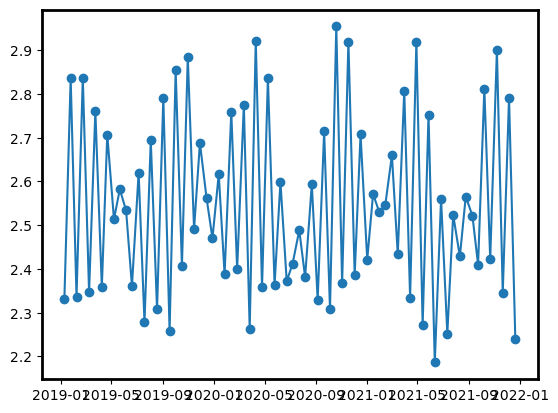

In [92]:
plt.plot(springhighs_px.time, springhighs_px.tide_m, marker='o')
plt.plot(springhighs_all_.time.isel(y=1,x=1), springhighs_all_.tide_m.isel(y=1,x=1), marker='o')

In [96]:
springhighs_all_.time#.isel(y=1,x=1)

<xarray.DataArray 'time' (dim_0: 74)>
array(['2019-01-01T00:00:00.000000000', '2019-01-01T03:00:00.000000000',
       '2019-01-01T06:00:00.000000000', '2019-01-01T09:00:00.000000000',
       '2019-01-01T12:00:00.000000000', '2019-01-01T15:00:00.000000000',
       '2019-01-01T18:00:00.000000000', '2019-01-01T21:00:00.000000000',
       '2019-01-02T00:00:00.000000000', '2019-01-02T03:00:00.000000000',
       '2019-01-02T06:00:00.000000000', '2019-01-02T09:00:00.000000000',
       '2019-01-02T12:00:00.000000000', '2019-01-02T15:00:00.000000000',
       '2019-01-02T18:00:00.000000000', '2019-01-02T21:00:00.000000000',
       '2019-01-03T00:00:00.000000000', '2019-01-03T03:00:00.000000000',
       '2019-01-03T06:00:00.000000000', '2019-01-03T09:00:00.000000000',
       '2019-01-03T12:00:00.000000000', '2019-01-03T15:00:00.000000000',
       '2019-01-03T18:00:00.000000000', '2019-01-03T21:00:00.000000000',
       '2019-01-04T00:00:00.000000000', '2019-01-04T03:00:00.000000000',
       '2019-01-04T06:00:00.000000000', '2019-01-04T09:00:00.000000000',
       '2019-01-04T12:00:00.000000000', '2019-01-04T15:00:00.000000000',
       '2019-01-04T18:00:00.000000000', '2019-01-04T21:00:00.000000000',
       '2019-01-05T00:00:00.000000000', '2019-01-05T03:00:00.000000000',
       '2019-01-05T06:00:00.000000000', '2019-01-05T09:00:00.000000000',
       '2019-01-05T12:00:00.000000000', '2019-01-05T15:00:00.000000000',
       '2019-01-05T18:00:00.000000000', '2019-01-05T21:00:00.000000000',
       '2019-01-06T00:00:00.000000000', '2019-01-06T03:00:00.000000000',
       '2019-01-06T06:00:00.000000000', '2019-01-06T09:00:00.000000000',
       '2019-01-06T12:00:00.000000000', '2019-01-06T15:00:00.000000000',
       '2019-01-06T18:00:00.000000000', '2019-01-06T21:00:00.000000000',
       '2019-01-07T00:00:00.000000000', '2019-01-07T03:00:00.000000000',
       '2019-01-07T06:00:00.000000000', '2019-01-07T09:00:00.000000000',
       '2019-01-07T12:00:00.000000000', '2019-01-07T15:00:00.000000000',
       '2019-01-07T18:00:00.000000000', '2019-01-07T21:00:00.000000000',
       '2019-01-08T00:00:00.000000000', '2019-01-08T03:00:00.000000000',
       '2019-01-08T06:00:00.000000000', '2019-01-08T09:00:00.000000000',
       '2019-01-08T12:00:00.000000000', '2019-01-08T15:00:00.000000000',
       '2019-01-08T18:00:00.000000000', '2019-01-08T21:00:00.000000000',
       '2019-01-09T00:00:00.000000000', '2019-01-09T03:00:00.000000000',
       '2019-01-09T06:00:00.000000000', '2019-01-09T09:00:00.000000000',
       '2019-01-09T12:00:00.000000000', '2019-01-09T15:00:00.000000000',
       '2019-01-09T18:00:00.000000000', '2019-01-09T21:00:00.000000000',
       '2019-01-10T00:00:00.000000000', '2019-01-10T03:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time         (dim_0) datetime64[ns] 2019-01-01 ... 2019-01-10T03:00:00
    tide_model   <U7 'FES2014'
    spatial_ref  int32 3577
Dimensions without coordinates: dim_0

In [80]:
springhighs_all = springhighs_all.to_dataset(name = 'peak_pos')#.isel(y=1,x=1).values

In [81]:
springhighs_all

<xarray.Dataset>
Dimensions:   (y: 23, x: 33, dim_0: 74)
Coordinates:
  * y         (y) float64 -1.288e+06 -1.288e+06 ... -1.286e+06 -1.286e+06
  * x         (x) float64 -1.405e+04 -1.395e+04 ... -1.095e+04 -1.085e+04
Dimensions without coordinates: dim_0
Data variables:
    peak_pos  (dim_0, y, x) int64 60 60 60 60 60 60 ... 8684 8684 8684 8684 8684

In [ ]:
## Calculate the neap high and low tides per 14 day half lunar cycle
# Calculate all the high tide maxima
Max_test = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values)[0])
# Calculate the neap high tide minima per half lunar cycle, based on the number of spring high maxima
neaphighs = np.array(argrelmin(test_mt[Max_test].values,
                              order=(int(ceil((len(test_mt[Max_test])/len(springhighs))/2))))[0])
# Calculate all the low tide minima
Min_test = np.array(argrelmin(modelledtides[0].isel(y=1,x=1).values)[0])
# Calculate the neap low tide maxima per half lunar cycle, based on the number of spring low minima
neaplows = np.array(argrelmax(test_mt[Min_test].values,
                              order=(int(ceil((len(test_mt[Min_test])/len(springlows))/2))))[0])

# if 'Spring_high':
#     time_range = test_mt[springhighs].time.values
# if 'Spring_low':
#     time_range = test_mt[springlows].time.values
# if 'Neap_high':
#     time_range = test_mt[Max_test][neaphighs].time.values
# if 'Neap_low':
#     time_range = test_mt[Min_test][neaplows].time.values

## Calculate all hightide and lowtide peaks

# Create a dataset to model into, same length as test_mt (modelledtides) but without 
# the complication of datetimes
count = np.arange(0,len(test_mt),1)

## Need to extract the maxima and minima from the high and low tide maxima respectively
Max_max = np.array(argrelmax(test_mt[Max_test].values)[0])
Max_min = np.array(argrelmin(test_mt[Max_test].values)[0])

Min_max = np.array(argrelmax(test_mt[Min_test].values)[0])
Min_min = np.array(argrelmin(test_mt[Min_test].values)[0])


## Interpolate the high and low spring and neap curves
# neap high tide curve
neap_high_linear = interp1d(Max_test[Max_min], 
                            test_mt[Max_test][Max_min].values, 
                            bounds_error=False, 
                            kind='linear', 
                            fill_value='extrapolate'
                           )
neap_high_testline = neap_high_linear(count)
# spring high tide curve
spring_high_linear = interp1d(Max_test[Max_max], 
                              test_mt[Max_test][Max_max].values, 
                              bounds_error=False, 
                              kind='linear', 
                              fill_value='extrapolate'
                             )
spring_high_testline = spring_high_linear(count)
# neap low tide curve
neap_low_linear = interp1d(Min_test[Min_max], 
                           test_mt[Min_test][Min_max].values, 
                           bounds_error=False, 
                           kind='linear', 
                           fill_value='extrapolate')
neap_low_testline = neap_low_linear(count)
# spring low tide curve
spring_low_linear = interp1d(Min_test[Min_min], 
                             test_mt[Min_test][Min_min].values, 
                             bounds_error=False, 
                             kind='linear', 
                             fill_value='extrapolate')
spring_low_testline = spring_low_linear(count)
# turn test_mt (modelledtides) into xr.Dataset
test_mt = test_mt.to_dataset()
# append the extrapolated tidelines for the lowest high tides and
# highest low tides (not really neap - more neap-esque)
test_mt['neap_high_testline'] = (('time'), neap_high_testline)
test_mt['neap_low_testline'] = (('time'), neap_low_testline)
# Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
hightide = test_mt['tide_m'].where(test_mt['tide_m'] >= test_mt['neap_high_testline'], drop=True)
# Extract lowtides as all tides lower than/equal to the extrapolated highest low tide line
lowtide = test_mt['tide_m'].where(test_mt['tide_m'] <= test_mt['neap_low_testline'], drop=True)
# Extract datetimes to run through exposure module
# if 'Hightide':
#     time_range = hightide.time.values
# if 'Lowtide':
#     time_range = lowtide.time.values